## Import Libraries and Read Data

In [1]:
import pandas as pd # For data manipulation and analysis
import numpy as np  # For numerical operations and array manipulation
import matplotlib.pyplot as plt  # For creating visualizations and plots
import seaborn as sns  # For statistical data visualization
import re
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
import pandas as pd
from wordcloud import WordCloud, STOPWORDS

from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig


plt.style.use('ggplot')

import nltk 

In [2]:
# Read data
df = pd.read_csv('C:/Users/user/Desktop/LastSemester/airflowInwi/dags/cleaned_comments_inwi.csv')
print(df.shape)

(659, 5)


In [3]:
df.head()

,comment_order,comment_date,comment_text,comment_likes,cleaned_comment_text
0,1,2024-11-21 17:28:19,\nWelcome to r/Morocco! Please always make sur...,1,\nWelcome to r/Morocco! Please always make sur...
1,2,2024-11-21 17:37:09,"i have it for a looong time, since they starte...",12,"i have it for a looong time, since they starte..."
2,3,2024-11-21 17:44:16,"Chfara, drt abonnement 3ndhom b 79dh, wslatni ...",12,"Chfara, drt abonnement 3ndhom b 79dh, wslatni ..."
3,4,2024-11-21 18:53:23,I have been a customer of Win for more than fo...,5,I have been a customer of Win for more than fo...
4,5,2024-11-21 17:42:49,"Pro: the deal is real, it's the cheapest mobil...",3,"Pro the deal is real, it's the cheapest mobile..."


In [4]:
stopwords = STOPWORDS
print(stopwords)

{"it's", 'whom', 'if', "i'd", 'there', "wasn't", "here's", 'not', 'shall', 'our', 'should', 'this', "couldn't", 'has', 'where', 'did', "she'll", "what's", 'on', 'ours', 'once', 'he', "haven't", 'here', 'i', 'am', 'that', 'very', 'by', 'cannot', 'however', 'again', 'have', 'just', 'herself', 'she', 'k', 'otherwise', 'in', 'off', 'doing', 'so', "you've", "why's", 'then', "they've", 'below', "we're", "can't", 'is', "they're", 'for', "they'd", 'therefore', 'them', "you'll", 'no', "i've", 'had', 'the', 'ourselves', 'were', 'they', 'own', 'with', 'under', "when's", 'why', 'what', 'above', 'down', 'or', 'yourselves', 'too', 'com', 'to', 'your', 'we', "we'd", "weren't", 'against', 'else', 'as', 'are', 'between', "wouldn't", "she's", 'was', 'because', 'an', "i'll", "that's", 'get', 'more', 'itself', "shan't", 'further', "she'd", 'you', 'my', 'could', 'few', 'be', 'both', "let's", 'me', 'until', 'all', "they'll", "shouldn't", 'most', 'at', 'her', 'only', 'theirs', 'who', 'and', 'over', 'through'

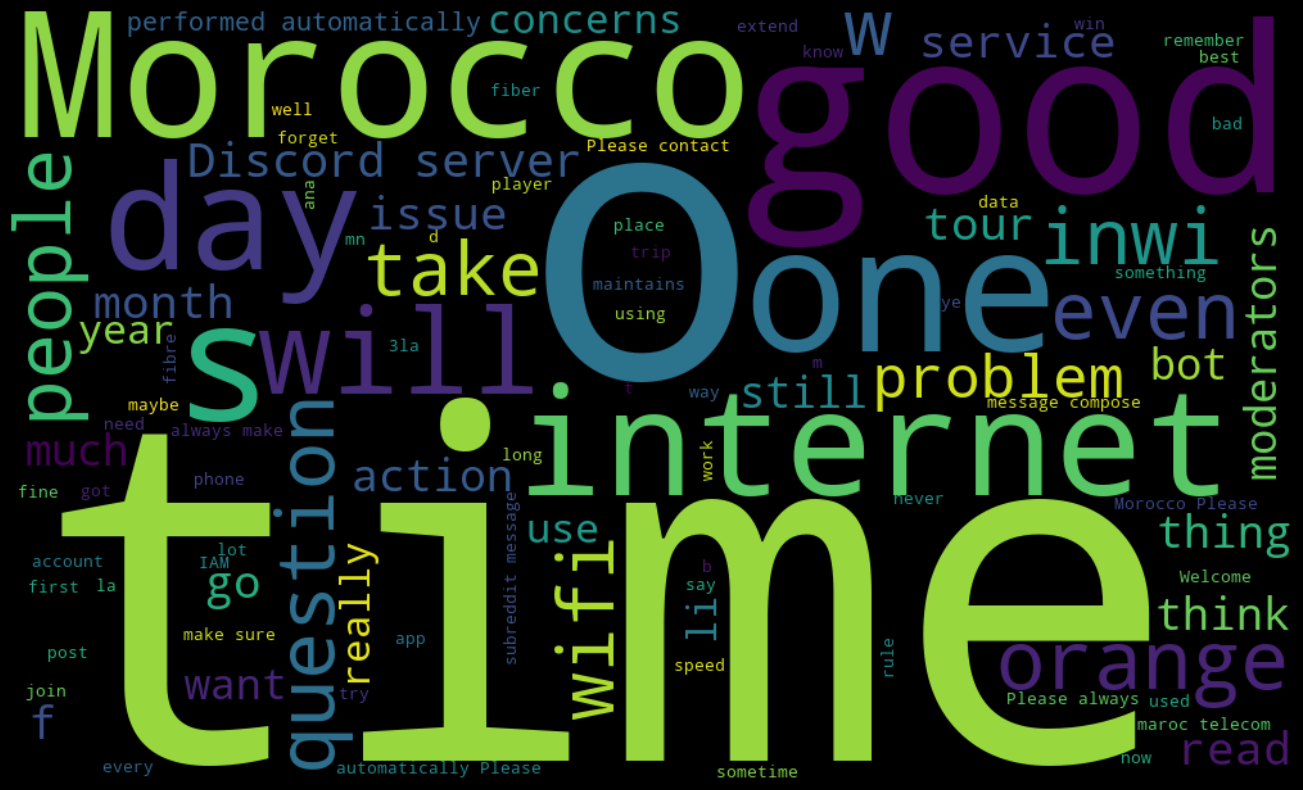

In [5]:
# Ensure all values are strings and handle NaN values
text = ' '.join([str(twts) for twts in df["cleaned_comment_text"].fillna("")])

# Generate word cloud
wordcloud = WordCloud(width=1000, height=600, 
                       max_words=100,
                       stopwords=stopwords,
                       background_color="black").generate(text)

# Display the generated image
plt.figure(figsize=(20, 10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Step 1. VADER Seniment Scoring


In [6]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [20]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [21]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [15]:
df.rename(columns={df.columns[0]: 'id'}, inplace=True)


In [16]:
# Remplacer les valeurs non valides par une chaîne vide
df['cleaned_comment_text'] = df['cleaned_comment_text'].apply(lambda x: str(x) if isinstance(x, str) else '')

# Puis, exécuter la même boucle pour les scores de polarité
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['cleaned_comment_text']
    myid = row['id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/647 [00:00<?, ?it/s]

In [17]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'id'})
vaders = vaders.merge(df, how='left')

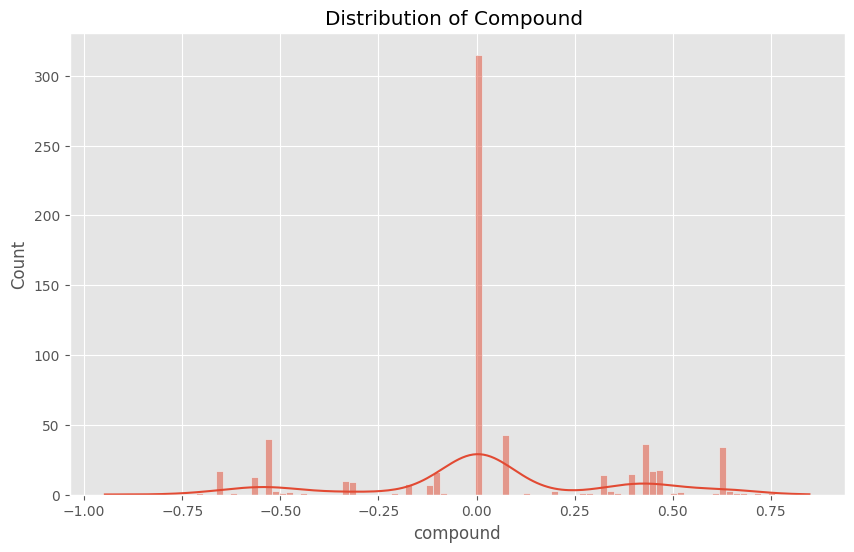

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(vaders['compound'], kde=True)
plt.title('Distribution of Compound ')
plt.show()

In [18]:
# Now we have sentiment score and metadata
vaders.head()

,id,neg,neu,pos,compound,comment_date,comment_text,comment_likes,cleaned_comment_text,sentiment,sentiment_score
0,1,0.0,0.435,0.565,0.0772,2024-11-21 17:28:19,\nWelcome to r/Morocco! Please always make sur...,1,welcome rmorocco please always make sure take ...,neutral,0.6908
1,1,0.0,0.435,0.565,0.0772,2024-10-28 18:58:20,\nWelcome to r/Morocco! Please always make sur...,1,welcome rmorocco please always make sure take ...,neutral,0.6908
2,1,0.0,0.435,0.565,0.0772,2024-10-27 20:36:01,Ah a fellow breaking bad fan🫵,2,ah fellow breaking bad fan,positive,0.4641
3,1,0.0,0.435,0.565,0.0772,2024-10-27 07:26:45,R5: I played Ming and stacked a threesome of a...,2,r5 played ming stacked threesome achievements ...,positive,0.5351
4,1,0.0,0.435,0.565,0.0772,2024-10-26 09:00:41,it’s the best drop of 2024 it’s tuff,7,best drop 2024 tuff,positive,0.5513


## Step 3 : twitter-roberta-base-sentiment-latest
This is a RoBERTa-base model trained on ~124M tweets from January 2018 to December 2021, and finetuned for sentiment analysis with the TweetEval benchmark. The original Twitter-based RoBERTa model can be found here and the original reference paper is TweetEval. This model is suitable for English.

In [7]:
import re
import pandas as pd
from nltk.corpus import stopwords

# Assurez-vous d'avoir téléchargé ces ressources si nécessaire
# import nltk
# nltk.download('stopwords')

# Initialisation des objets nécessaires
stop_words = set(stopwords.words('english'))  # Ou la langue de votre choix

# Fonction pour nettoyer chaque commentaire sans tokenisation ni lemmatisation
def clean_text(text):
    # Assurez-vous que le texte est bien une chaîne de caractères
    if not isinstance(text, str):
        return ""  # Retourner une chaîne vide si ce n'est pas une string
    
    # 1. Supprimer les emojis
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Enlève tous les caractères non-ASCII (y compris emojis)
    
    # 2. Supprimer les nombres flottants
    text = re.sub(r'\d+\.\d+', '', text)  # Supprime les nombres flottants (par exemple 12.34)
    
    # 3. Supprimer les doublons dans le texte
    text = ' '.join(sorted(set(text.split()), key=text.split().index))  # Enlever les doublons dans l'ordre
    
    # 4. Convertir en minuscules
    text = text.lower()

    # 5. Retirer la ponctuation
    text = re.sub(r'[^\w\s]', '', text)  # Supprimer toute la ponctuation
    
    # 6. Supprimer les stopwords sans tokenisation
    text = ' '.join([word for word in text.split() if word not in stop_words])

    return text

# Appliquer la fonction de nettoyage à la colonne 'cleaned_comment_text'
# Convertir d'abord les valeurs non-string en chaînes vides
df['cleaned_comment_text'] = df['cleaned_comment_text'].apply(lambda x: str(x) if isinstance(x, str) else "")

# Appliquer la fonction de nettoyage
df['cleaned_comment_text'] = df['cleaned_comment_text'].apply(clean_text)

# Optionnel : Supprimer les commentaires vides après nettoyage
df = df[df['cleaned_comment_text'].str.strip() != '']

# Afficher un exemple du DataFrame nettoyé
print(df[['cleaned_comment_text']].head())


                                cleaned_comment_text
0  welcome rmorocco please always make sure take ...
1  looong time since started used game first 2 ye...
2  chfara drt abonnement 3ndhom b 79dh wslatni si...
3   customer win four years never one single problem
4  pro deal real cheapest mobile data 15gb 1h tal...


In [25]:
%pip install tiktoken


Note: you may need to restart the kernel to use updated packages.Collecting tiktoken
   ---------------------------------------- 0.0/883.8 kB ? eta -:--:--
   ---------------------------------------- 0.0/883.8 kB ? eta -:--:--
   ---------------------------------------- 0.0/883.8 kB ? eta -:--:--
   ---------------------------------------- 0.0/883.8 kB ? eta -:--:--
   ---------------------------------------- 0.0/883.8 kB ? eta -:--:--
   ---------------------------------------- 0.0/883.8 kB ? eta -:--:--
   ---------------------------------------- 0.0/883.8 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/883.8 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/883.8 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/883.8 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/883.8 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/883.8 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/883


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
import pandas as pd
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
from scipy.special import softmax
import numpy as np

# Charger le modèle et le tokenizer
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Fonction de prétraitement pour les mentions et les URLs
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# Fonction pour obtenir la prédiction de sentiment
def get_sentiment_score(text):
    text = preprocess(text)  # Appliquer le prétraitement
    encoded_input = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)  # Tronquer à 512 tokens
    output = model(**encoded_input)  # Obtenir la prédiction du modèle
    scores = output[0][0].detach().numpy()  # Extraire les scores
    scores = softmax(scores)  # Appliquer softmax pour normaliser les scores
    
    # Trier les scores
    ranking = np.argsort(scores)[::-1]
    
    # Retourner la première classe (la plus probable) et son score
    sentiment_label = config.id2label[ranking[0]]  # Sentiment (positif, négatif, neutre)
    sentiment_score = np.round(float(scores[ranking[0]]), 4)  # Score du sentiment
    
    return sentiment_label, sentiment_score

# Assurez-vous que les données sont propres et non vides
df['cleaned_comment_text'] = df['cleaned_comment_text'].fillna('')  # Remplacer les NaN
df = df[df['cleaned_comment_text'].str.strip().astype(bool)]  # Supprimer les lignes vides

# Appliquer le modèle à chaque commentaire dans la colonne 'cleaned_comment_text'
df[['sentiment', 'sentiment_score']] = df['cleaned_comment_text'].apply(lambda x: pd.Series(get_sentiment_score(x)))

# Afficher les résultats
print(df[['cleaned_comment_text', 'sentiment', 'sentiment_score']].head())


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


                                cleaned_comment_text sentiment  \
0  welcome rmorocco please always make sure take ...   neutral   
1  looong time since started used game first 2 ye...  positive   
2  chfara drt abonnement 3ndhom b 79dh wslatni si...   neutral   
3   customer win four years never one single problem  positive   
4  pro deal real cheapest mobile data 15gb 1h tal...  positive   

   sentiment_score  
0           0.6908  
1           0.9347  
2           0.7774  
3           0.6995  
4           0.8588  


C:\Users\user\AppData\Local\Temp\ipykernel_10156\1613919231.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")


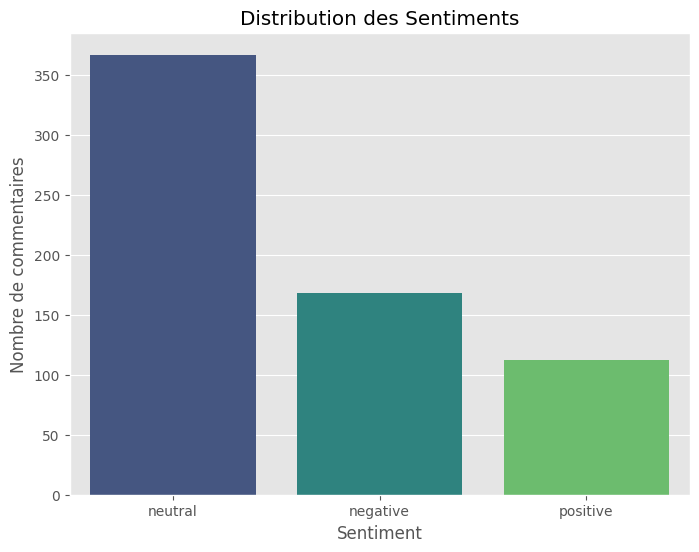

In [13]:
# Compter le nombre de chaque sentiment
sentiment_counts = df['sentiment'].value_counts()

# Tracer un graphique en barres
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")
plt.title('Distribution des Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Nombre de commentaires')
plt.show()


In [9]:
%pip install --upgrade transformers sentencepiece


   ---------------------------------------- 0.0/992.0 kB ? eta -:--:--
   ------------------------------- -------- 786.4/992.0 kB 5.6 MB/s eta 0:00:01
   ------------------------------- -------- 786.4/992.0 kB 5.6 MB/s eta 0:00:01
   ------------------------------- -------- 786.4/992.0 kB 5.6 MB/s eta 0:00:01
   ---------------------------------------- 992.0/992.0 kB 1.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Step 4 : Negative Comments

In [12]:
negative_comments = df[df['sentiment'] == 'negative']


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Vectorisation avec TF-IDF
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')  # Ajustez les paramètres selon vos besoins
X = vectorizer.fit_transform(negative_comments['cleaned_comment_text'])

# Appliquer LDA pour trouver des sujets
lda = LatentDirichletAllocation(n_components=5, random_state=42)  # 5 sujets, ajustez selon vos besoins
lda.fit(X)

# Afficher les mots clés pour chaque sujet
terms = vectorizer.get_feature_names_out()
n_top_words = 10  # Nombre de mots à afficher pour chaque sujet
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic #{topic_idx}:")
    print(" ".join([terms[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

Topic #0:
long comment issue bombed similar think scam service leave sleep

Topic #1:
want use phone rom fibre inwi good ai sure iam

Topic #2:
kamlin expensive wifi istg year company fucking services didnt fibre

Topic #3:
place day shitty inwi orange mn isnt problem trash cafe

Topic #4:
im dont thats need agree expensive internet way like pay

